### Backtesting of Trading Strategies for Bitcoin - A Replication

See thesis by Glucksmann, supervised by Sornette - Backtesting of Trading Strategies for Bitcoin [2019] 

An attempt to replicate the strategy described there in Backtrader.

In [3]:
import time
import math
import datetime as dt
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import backtrader as bt

In [4]:
# loads OHLC data from path and returns dataframe object
# assumes that data contains Unix Timestamp, i.e. seconds since epoch, and converts to datetime
# sets Timestamp as index

def load_data(path):
    df = pd.read_csv(path)
    df['Timestamp'] = df['Timestamp'].apply(dt.datetime.utcfromtimestamp)
    df.set_index('Timestamp', inplace=True)
    df.dropna(inplace=True)
    return df

In [5]:
path = r"C:\Users\brian\Desktop\coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09 (2).csv"
df = load_data(path)
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2014-12-01 05:33:00,300.0,300.0,300.0,300.0,0.010000,3.00000,300.0
2014-12-01 05:40:00,300.0,300.0,300.0,300.0,0.010000,3.00000,300.0
2014-12-01 06:24:00,370.0,370.0,370.0,370.0,0.010000,3.70000,370.0
2014-12-01 06:50:00,370.0,370.0,370.0,370.0,0.026556,9.82555,370.0
2014-12-02 05:29:00,377.0,377.0,377.0,377.0,0.010000,3.77000,377.0


In [6]:
class MACD_Strat(bt.Strategy):
    '''
    Cribbed directly from Backtrader, just for testing/benchmarking 
    
    This strategy is loosely based on some of the examples from the Van
    K. Tharp book: *Trade Your Way To Financial Freedom*. The logic:

      - Enter the market if:
        - The MACD.macd line crosses the MACD.signal line to the upside
        - The Simple Moving Average has a negative direction in the last x
          periods (actual value below value x periods ago)

     - Set a stop price x times the ATR value away from the close

     - If in the market:

       - Check if the current close has gone below the stop price. If yes,
         exit.
       - If not, update the stop price if the new stop price would be higher
         than the current
    '''

    params = (
        # Standard MACD Parameters
        ('macd1', 12),
        ('macd2', 26),
        ('macdsig', 9),
        ('atrperiod', 14),  # ATR Period (standard)
        ('atrdist', 3.0),   # ATR distance for stop price
        ('smaperiod', 30),  # SMA Period (pretty standard)
        ('dirperiod', 10),  # Lookback period to consider SMA trend direction
    )

    def notify_order(self, order):
        if order.status == order.Completed:
            pass

        if not order.alive():
            self.order = None  # indicate no order is pending

    def __init__(self):
        self.macd = bt.indicators.MACD(self.data,
                                       period_me1=self.p.macd1,
                                       period_me2=self.p.macd2,
                                       period_signal=self.p.macdsig)

        # Cross of macd.macd and macd.signal
        self.mcross = bt.indicators.CrossOver(self.macd.macd, self.macd.signal)

        # To set the stop price
        self.atr = bt.indicators.ATR(self.data, period=self.p.atrperiod)

        # Control market trend
        self.sma = bt.indicators.SMA(self.data, period=self.p.smaperiod)
        self.smadir = self.sma - self.sma(-self.p.dirperiod)

    def start(self):
        self.order = None  # sentinel to avoid operrations on pending order

    def next(self):
        if self.order:
            return  # pending order execution

        if not self.position:  # not in the market
            if self.mcross[0] > 0.0 and self.smadir < 0.0:
                self.order = self.buy()
                pdist = self.atr[0] * self.p.atrdist
                self.pstop = self.data.close[0] - pdist

        else:  # in the market
            pclose = self.data.close[0]
            pstop = self.pstop

            if pclose < pstop:
                self.close()  # stop met - get out
            else:
                pdist = self.atr[0] * self.p.atrdist
                # Update only if greater than
                self.pstop = max(pstop, pclose - pdist)

In [10]:
# contains Backtrader boilerplate for running a backtest
# takes class name of Strategy as input
# intializes Cerebro engine, add Strategy
# loads data from Pandas path, as specified
# intializes broker, sets sizer
# and runs and plots backtest

def runStrategy():
    # initialize engine & strategy
    cerebro = bt.Cerebro()
    cerebro.addstrategy(Glucksmann)
    
    # load data from file into strategy
    path = r"C:\Users\brian\Desktop\coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09 (2).csv"
    df = load_data(path)
    df = df[:].drop(['Volume_(Currency)', 'Weighted_Price'], axis=1)
    # ignoring Current Volume and Weighted Price
    data = bt.feeds.PandasData(dataname=df,
                                fromdate=dt.datetime(2017, 2, 15),
                                todate=dt.datetime(2018, 2, 16),
                                datetime=None,
                                open='Open',
                                high='High',
                                low='Low',
                                close='Close',
                                volume='Volume_(BTC)',
                                openinterest=None
                            )
    cerebro.adddata(data)

    # initialize broker for trading
    cerebro.broker.setcash(1000000.0)
    cerebro.broker.setcommission(commission=0.001)
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # run strategy & plot 
    print('Starting Portfolio Value: %2f' % cerebro.broker.getvalue())
    cerebro.run()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot()

In [ ]:
"""
# VolatilityLevelIndicator (VLI) indicator, designed by Glucksmann
# derived from Bolinger Bands Witdth indicator 

class VolatilityLevelIndicator(bt.Indicators):
"""   

In [7]:
# strategy logic from Glucksmann [2019] thesis, supervised by Sornette
# "New Long" TA strategy, with claimed 2.8 sharpe & 22% max drawdown from 4/1/2015 - 3/1/2019
# using Bollinger Band Width, custom "VLI" indicator, SMA for signal
# additional stop loss/stop win points for exit

class Glucksmann(bt.Strategy):
    params = dict(sma_veryfast = 10,
                  sma_fast = 20,
                  sma_mid = 50,
                  sma_slow = 100,
                  sma_veryslow = 200,
                  bbw_sma_fast = 200,
                  bbw_sma_slow = 1000,
                  printlog=False
                 )
    
    
    def log(self, txt, dt=None):
        # Logging function for stratgy
        if self.params.printlog:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))
    
    
    def __init__(self):
        # close price SMAs
        self.sma_veryfast = bt.indicators.SMA(self.data.close, period=self.p.sma_veryfast)
        self.sma_fast = bt.indicators.SMA(self.data.close, period=self.p.sma_fast)
        self.sma_mid = bt.indicators.SMA(self.data.close, period=self.p.sma_mid)
        self.sma_slow = bt.indicators.SMA(self.data.close, period=self.p.sma_slow)
        self.sma_veryslow = bt.indicators.SMA(self.data.close, period=self.p.sma_veryslow)
        
        # bolinger bands width
        self.bol = bt.indicators.BollingerBands(self.data.close, period=self.p.sma_fast)
        self.bol_width = (self.bol.lines.top - self.bol.lines.bot) / self.bol.lines.mid
        self.bol_width_sig = bt.indicators.SMA(self.bol_width, period=self.p.sma_veryfast) > bt.indicators.SMA(self.bol_width, period=self.p.sma_mid)
        self.bol_top_xd = bt.indicators.CrossDown(self.data.close, self.bol.lines.top)
        self.bol_bot_xd = bt.indicators.CrossDown(self.data.close, self.bol.lines.bot)
        
        # volatility signal
        self.vol_sig = bt.indicators.SMA(self.data.volume, period=self.p.sma_fast) > bt.indicators.SMA(self.data.volume, period=self.p.sma_slow)
        
        # Volatility Level Indicator (VLI) logic
        self.vli_sma_fast = bt.indicators.SMA(self.bol_width, period=self.p.bbw_sma_fast)
        self.vli_sma_slow = bt.indicators.SMA(self.bol_width, period=self.p.bbw_sma_slow)
        self.vli_top = self.vli_sma_slow + 2 * bt.indicators.StandardDeviation(self.bol_width, period=self.p.bbw_sma_slow)
        self.low_vol_level = self.vli_sma_fast < self.vli_sma_slow
        self.high_vol_level = self.vli_sma_fast > self.vli_sma_slow
        self.extreme_vol = self.bol_width > self.vli_top
        
        self.stoploss = None
        self.stopwin = None
        self.low_sw_flag = False
        
        # keep track of pending orders and buy price/commission
        #self.position = None
        self.order = None
        self.buyval = 0
        self.trade_profit = 0
        self.buycomm = None
        
    def notify_order(self, order):
        
        if order.status in [order.Submitted, order.Accepted]:
            # buy/sell order submitted/accepted at broker, no action
            return

        # check if order has been  completed
        # note -- broker can reject order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'SELL EXECUTED, Price: %.2f, Size: %.2f, Cost: %.2f, Comm: %.2f' %
                    (order.executed.price,
                     order.executed.size,
                    order.executed.value,
                    order.executed.comm)
                )
                
                
                self.buyprice = order.executed.price
                self.buyval = order.executed.value
                self.buycomm = order.executed.comm
                
            else: #  sell
                self.log(
                    'SELL EXECUTED, Price: %.2f, Size: %.2f, Cost: %.2f, Comm: %.2f' %
                    (order.executed.price,
                     order.executed.size,
                    order.executed.value,
                    order.executed.comm)
                )

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # write down: no pending order
        self.order = None


    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        
        # log stats from closed trade position
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
            (trade.pnl, trade.pnlcomm)
        )
                
        self.stoploss = None
        self.stopwin = None
        self.low_sw_flag = False
        self.buyprice = 0
        self.trade_profit = 0
        
        
    def set_stopwin(self):
        if self.low_sw_flag == True:
            if self.trade_profit > 0.03:
                self.stopwin = 0.01
        else:
            if self.trade_profit > .4:
                self.stopwin = .35
            elif self.trade_profit > .35:
                self.stopwin = .3
            elif self.trade_profit > .3:
                self.stopwin = .25
            elif self.trade_profit > .25:
                self.stopwin = .2
            elif self.trade_profit > .2:
                self.stopwin = .15        
        

    def next(self): # core definition of strategy logic, for each timestep
        # simply log the closing price of the series from reference
        #self.log('Close, %.2f' % self.data.close[0])

        # check if order is pending -- won't send anoother
        if self.order:
            return
        
        #self.position = self.getposition()
        #print(self.position)
        #print(not self.position)

        # check if we are in the market, if not may buy
        if not self.position:
            if self.bol_top_xd[0] and self.vol_sig[0]:
                if self.data.close[0] > self.sma_fast[0]:
                    if self.bol_width[0] < self.vli_top[0]:
                        if self.low_vol_level[0]:
                            if self.sma_mid[0] > self.sma_veryslow[0]:
                                self.buy()
                                self.log('BUY CREATE, %.2f' % self.data.close[0])
                                self.stoploss = self.data.low[0] * 0.95
                        elif not self.sma_veryslow[0] > self.sma_slow[0] > self.sma_mid[0]:
                            self.buy()
                            self.log('BUY CREATE, %.2f' % self.data.close[0])
                            self.stoploss = self.data.low[0] * 0.95
                    elif self.sma_slow[0] > self.sma_veryslow[0]:
                        self.low_sw_flag = True
                        self.buy()
                        self.log('BUY CREATE, %.2f' % self.datas[0].close[0]) 
                        self.stoploss = self.data.low[-1]
                        self.set_stopwin()
                        # stopwin? if trade_profit > 3% then stopwin = 1%?
                        
        if self.position:
            if self.buyval != 0: self.trade_profit = ((self.position.size * self.data.close[0]) / self.buyval) - 1
            #self.log('trade_profit: %.2f' % self.trade_profit)
            self.set_stopwin() 
            if self.trade_profit != 0 and self.stopwin is not None: 
                if self.trade_profit < self.stopwin:
                    self.sell()
                    self.log('SELL CREATE, %.2f' % self.data.close[0]) 
                    self.buyval = 0
            if self.bol_bot_xd and self.vol_sig:
                self.sell()
                self.log('SELL CREATE, %.2f' % self.data.close[0]) 
                self.buyval = 0
                
        

C:\Users\brian\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


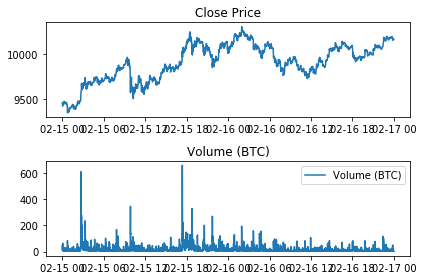

In [8]:
fig = plt.figure(1)
ax = plt.subplot(2, 1, 1)
ax.plot(df['2018-02-15':'2018-02-16']['Close'], label='Close')
ax2 = plt.subplot(2, 1, 2)
ax2.plot(df['2018-02-15':'2018-02-16']['Volume_(BTC)'], label='Volume (BTC)')
ax.set_title('Close Price')
ax2.set_title('Volume (BTC)')
plt.legend()
plt.tight_layout()
plt.show()

Starting Portfolio Value: 1000000.000000
Final Portfolio Value: 34912140.25


<IPython.core.display.Javascript object>

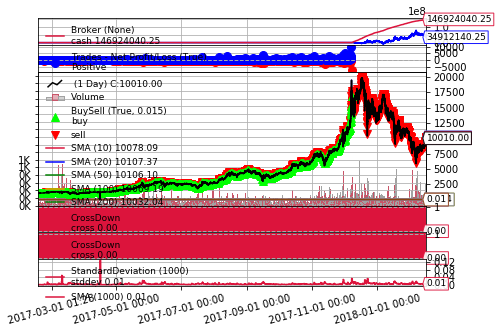

In [11]:
runStrategy()